In [43]:
import numpy as np

from utils import *
from core import *
import imageio.v3 as iio
from PIL import Image

im = iio.imread('../assets/800px-SheppLogan.png')

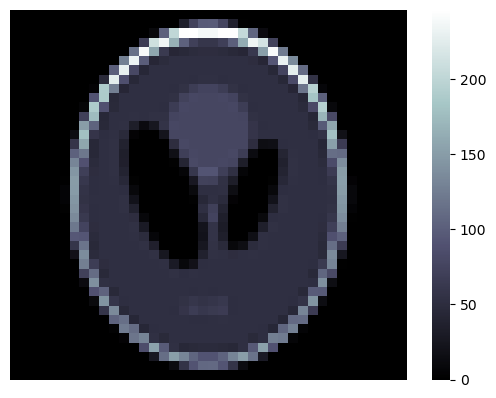

In [44]:
# loading image
new_res = 40

img = Image.fromarray(im).resize((new_res, new_res))
img = np.array(img.convert('L'))
plot_image(img, cmap='bone')

In [45]:
A = CreateInterceptMatrix(
  no_of_detectors=2*new_res,
  source_to_object=20,
  source_to_detector=42,
  size_of_object=12,
  no_of_rotations=new_res,
  angle_bw_detectors=0.01652/4,
  resolution=new_res
).create_intercept_matrix_from_lines()

## Forward Problem

solving the forward problem of obtaining detector readings using image matrix (shepp Logan)

In [46]:
b = A @ img.flatten()
b.shape

(3200,)

## Backward Problem

In [47]:
# GPU based pinv calc

import torch
torch.set_default_device('cuda')
A = torch.from_numpy(A).cuda()

In [48]:

def power_iteration(A, num_iterations):
    """
    power iterations to find out 1 eigenvector of given matrix
    """
    b = torch.rand(A.shape[1], dtype=torch.double)

    for _ in range(num_iterations):
        Ab = torch.mv(A, b)

        norm = torch.linalg.vector_norm(Ab)
        b = torch.div(Ab, norm)

    return b

def svd(A, num_iterations=1000, tol=1e-8):
    """
    return SVD of matrix A, S will be of (r,r) dimensions where r is rank of matrix A
    equivalent to numpy's np.linalg.svd(A, full_natrices=False) with tolerance for singular values
    """
    ATA = torch.mm(A.T, A)

    V = []
    S = []
    i = 0
    # finding right singular vectors
    for _ in tqdm(range(min(ATA.shape)), desc='Performing decomposition'):
        eigenvector = power_iteration(ATA, num_iterations)
        eigenvalue = torch.linalg.multi_dot([eigenvector, ATA, eigenvector])
        if eigenvalue < tol:
            break


        eigenvector /= torch.norm(eigenvector)

        V.append(eigenvector)
        S.append(eigenvalue)

        # reduce lambda * vT v from the eigendecomposition of AtA
        ATA = ATA - eigenvalue * torch.outer(eigenvector, eigenvector)

    if not S:
        raise ValueError('Matrix has rank 0')

    S = torch.sqrt(torch.tensor(S, dtype=torch.double))

    # find the left singular vectors
    V = torch.column_stack(V)
    U = torch.linalg.multi_dot([A, V, torch.diag(1/S)])
    return U, S, V.T

def pinv(A, num_iterations=1000, tol=1e-8):
    U, S, Vt = svd(A, num_iterations, tol)
    return torch.linalg.multi_dot([Vt.T, torch.diag(1/S), U.T])

In [49]:
A_pinv = pinv(A, num_iterations=200)

Performing decomposition:  97%|█████████▋| 1557/1600 [02:21<00:03, 10.99it/s]


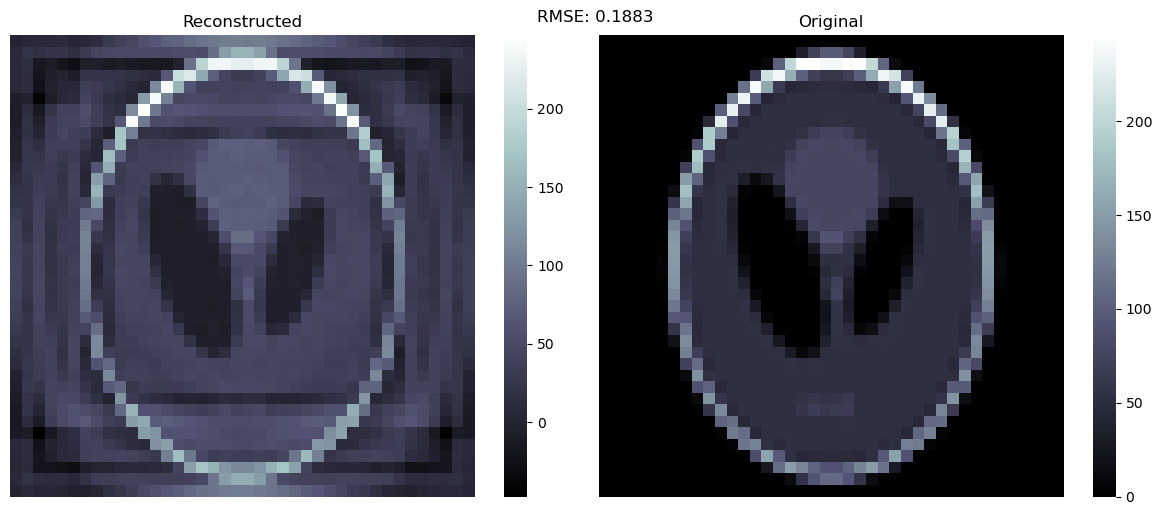

In [50]:
A_pinv_rounded = torch.round(A_pinv, decimals=4)
b = torch.from_numpy(b).cuda()
x = torch.mv(A_pinv_rounded, b)
x = np.array(x.cpu())
plot_images(x.reshape(new_res, -1), img, cmap='bone')